# Chinese characters generator 

In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2DTranspose, Conv2D
from keras.layers.advanced_activations import LeakyReLU

from keras.optimizers import SGD, RMSprop

Using TensorFlow backend.


## Data

In [3]:
filename = "./data/vector300_2hier64x64_27_01_18_11_01_02.txt"

X_vec = []
Y_img = []

img_size = 64
wcount = 0
for line in open(filename):
    vec, img = line[:-1].split(",")
    
    vec = np.array([float(n) for n in vec.split(" ")])
    img = np.array([(float(n) - 127) / 127 for n in img.split(" ")])
        
    img = np.reshape(img, (img_size, img_size, 1))
    
    X_vec.append(vec)
    Y_img.append(img)
    
    wcount += 1
    if (wcount % 10000 == 0):
        print("{} words processed".format(wcount))
    if wcount > 200000:
        break
        
print("{} words processed".format(wcount))

Y_img = np.array(Y_img)
X_vec = np.array(X_vec)

10000 words processed
20000 words processed
30000 words processed
40000 words processed
50000 words processed
60000 words processed
70000 words processed
80000 words processed
90000 words processed
100000 words processed
110000 words processed
120000 words processed
126007 words processed


In [4]:
Y_img.shape, np.min(Y_img), np.max(Y_img)

((126007, 64, 64, 1), -1.0, 1.0078740157480315)

## Visualisation

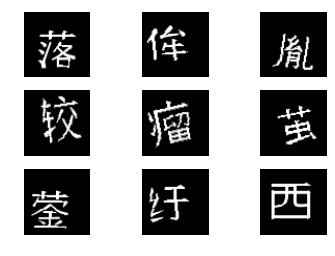

In [5]:
images = Y_img[np.random.randint(0, Y_img.shape[0], 
                                 size=9)]

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(images[i].reshape(img_size, img_size), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

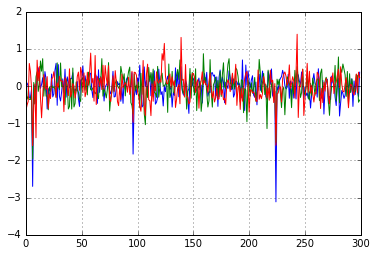

In [6]:
vectors = X_vec[np.random.randint(0, X_vec.shape[0], 
                                  size=3)]

for i in range(3):
    plt.plot(vectors[i])
    
plt.grid()
plt.show()

# GAN
## Generator

In [107]:
gen_dropout = 0.3
gen_input_dim = 8
gen_depth = 512
gen_noise_dim = 300
# gen_alpha = 0.2
gen_beta = 0.9

In [109]:
gennet = Sequential()

# Input 
# fully-connected layer
gennet.add(Dense(gen_input_dim * gen_input_dim * gen_depth, 
                 input_dim=gen_noise_dim))
gennet.add(Reshape((gen_input_dim, gen_input_dim, gen_depth)))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
gennet.add(Dropout(gen_dropout))

# Deconvolution layers
gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 2), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))

# gennet.add(Conv2DTranspose(int(gen_depth / 2), 5, padding='same'))
# gennet.add(BatchNormalization(momentum=gen_beta))
# gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))


gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 4), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))

gennet.add(Conv2DTranspose(int(gen_depth / 4), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))


gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 8), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))

gennet.add(Conv2DTranspose(int(gen_depth / 8), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))


# gennet.add(UpSampling2D())
gennet.add(Conv2DTranspose(int(gen_depth / 16), 5, padding='same'))
gennet.add(BatchNormalization(momentum=gen_beta))
gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))

# gennet.add(Conv2DTranspose(int(gen_depth / 16), 5, padding='same'))
# gennet.add(BatchNormalization(momentum=gen_beta))
# gennet.add(Activation('relu'))
# gennet.add(Dropout(gen_dropout))

# Output
gennet.add(Conv2DTranspose(1, 5, padding='same'))
gennet.add(Activation('tanh'))

gennet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 32768)             9863168   
_________________________________________________________________
reshape_11 (Reshape)         (None, 8, 8, 512)         0         
_________________________________________________________________
batch_normalization_103 (Bat (None, 8, 8, 512)         2048      
_________________________________________________________________
activation_97 (Activation)   (None, 8, 8, 512)         0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 8, 8, 512)         0         
_________________________________________________________________
up_sampling2d_35 (UpSampling (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_transpose_79 (Conv2DT (None, 16, 16, 256)       3277056   
__________

## Discriminator

In [111]:
disc_depth = 64
disc_dropout = 0.3
disc_alpha = 0.0
disc_beta = 0.9

In [112]:
discnet = Sequential()

# Input
discnet.add(Conv2D(disc_depth, 5, strides=2, input_shape=(img_size, img_size, 1), 
                   padding='same'))
# discnet.add(BatchNormalization(momentum=disc_beta))
discnet.add(LeakyReLU(alpha=disc_alpha))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*2, 5, strides=2, padding='same'))
# discnet.add(BatchNormalization(momentum=disc_beta))
discnet.add(LeakyReLU(alpha=disc_alpha))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*4, 5, strides=2, padding='same'))
# discnet.add(BatchNormalization(momentum=disc_beta))
discnet.add(LeakyReLU(alpha=disc_alpha))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*8, 5, strides=2, padding='same'))
# discnet.add(BatchNormalization(momentum=disc_beta))
discnet.add(LeakyReLU(alpha=disc_alpha))
discnet.add(Dropout(disc_dropout))

discnet.add(Conv2D(disc_depth*16, 5, strides=2, padding='same'))
# discnet.add(BatchNormalization(momentum=disc_beta))
discnet.add(LeakyReLU(alpha=disc_alpha))
discnet.add(Dropout(disc_dropout))

# Out: scalar estimation of probability
discnet.add(Flatten())
discnet.add(Dense(1))
discnet.add(Activation('sigmoid'))

discnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 32, 32, 64)        1664      
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 8, 8, 256)         819456    
__________

## Discriminator model

In [113]:
discmodel = Sequential()
discmodel.add(discnet)
discmodel.compile(loss='binary_crossentropy', 
#                   optimizer=SGD(lr=0.0002),
                  optimizer=RMSprop(lr=0.0002, clipvalue=1.0, decay=6e-8),
                  metrics=['accuracy'])

## Adversarial model

In [114]:
advmodel = Sequential()
advmodel.add(gennet)
advmodel.add(discnet)
advmodel.compile(loss='binary_crossentropy', 
#                  optimizer=SGD(lr=0.0001),
                 optimizer=RMSprop(lr=0.0001, clipvalue=1.0, decay=3e-8),
                 metrics=['accuracy'])

## Training

In [115]:
disc_losses = {"loss": [], "acc": []}
adv_losses = {"loss": [], "acc": []}

In [121]:
batch_size = 128
train_iters = 1500
stop_loss = 7.0

disc_loss = [1.0, 0.0]
adv_loss = [1.0, 0.0]

log_i = 0

start_time = time.time()

for i in range(train_iters):
        # Compose trainig data for adversarial net
#     noise = np.random.normal(size=[batch_size, gen_noise_dim])
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, gen_noise_dim])
    y = np.ones([batch_size, 1])
    # Train adversarial net on composed data
    adv_loss = advmodel.train_on_batch(noise, y)
    adv_losses["loss"].append(adv_loss[0])
    adv_losses["acc"].append(adv_loss[1])
    
    # Get random real images
    images_true = Y_img[np.random.randint(0, 
                                          Y_img.shape[0], 
                                          size=batch_size)]
    # Generate images from noise
#     if np.random.randint(0, 2):
    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, gen_noise_dim])
#     noise = np.random.normal(size=[batch_size, gen_noise_dim])
    images_fake = gennet.predict(noise)
    # Compose training data for discriminator
    x = np.concatenate((images_true, images_fake))
    y = np.concatenate((np.ones((batch_size, 1)), 
                        np.zeros((batch_size, 1))))
    # Train discriminator on composed data
    disc_loss = discmodel.train_on_batch(x, y)
    disc_losses["loss"].append(disc_loss[0])
    disc_losses["acc"].append(disc_loss[1])
    
    # Break if too big losses
#     if disc_loss[0] > stop_loss or adv_loss[0] > stop_loss:
#         print("Too big losses. Disc {:.3f} | Adv {:.3f}".format(disc_loss[0], adv_loss[0]))
#         break
        
#     if disc_loss[1] == 1.0:
#         print("Disc doesn't learns.")
#         break
    
    # Print results
    if i % 100 == 0:
        curr_time = time.time()
        if i > 0:
            time_est = (curr_time - start_time) * (train_iters - i) / i
        else:
            time_est = (curr_time - start_time) * train_iters
        time_est_str = str(timedelta(seconds=time_est)).split('.')[0]
        print("{:4d}th batch of {:4d}|".format(i, train_iters) + \
              "Disc loss {:.3f} |Disc acc {:.3f} |Adv loss {:.3f} |Adv acc {:.3}|".format(disc_loss[0], 
                                                                                          disc_loss[1], 
                                                                                          adv_loss[0], 
                                                                                          adv_loss[1]) +\
              "Time est {}".format(time_est_str))

   0th batch of 1500|Disc loss 0.754 |Disc acc 0.500 |Adv loss 0.656 |Adv acc 0.859|Time est 0:18:33
 100th batch of 1500|Disc loss 0.730 |Disc acc 0.500 |Adv loss 1.135 |Adv acc 0.0|Time est 0:17:44
 200th batch of 1500|Disc loss 0.705 |Disc acc 0.496 |Adv loss 0.704 |Adv acc 0.383|Time est 0:16:28
 300th batch of 1500|Disc loss 0.687 |Disc acc 0.516 |Adv loss 0.730 |Adv acc 0.102|Time est 0:15:11
 400th batch of 1500|Disc loss 0.686 |Disc acc 0.559 |Adv loss 0.868 |Adv acc 0.0|Time est 0:13:55
 500th batch of 1500|Disc loss 0.725 |Disc acc 0.492 |Adv loss 0.685 |Adv acc 0.578|Time est 0:12:39
 600th batch of 1500|Disc loss 0.752 |Disc acc 0.500 |Adv loss 0.669 |Adv acc 0.742|Time est 0:11:23
 700th batch of 1500|Disc loss 0.693 |Disc acc 0.516 |Adv loss 0.712 |Adv acc 0.289|Time est 0:10:07
 800th batch of 1500|Disc loss 0.695 |Disc acc 0.477 |Adv loss 0.709 |Adv acc 0.336|Time est 0:08:51
 900th batch of 1500|Disc loss 0.714 |Disc acc 0.504 |Adv loss 0.668 |Adv acc 0.633|Time est 0:

## Losses

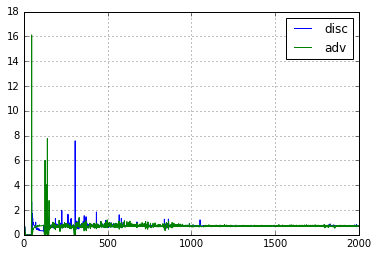

In [122]:
plt.plot(disc_losses["loss"], label="disc")
plt.plot(adv_losses["loss"], label="adv")
plt.grid()
plt.legend()
plt.show()

## Accuracies

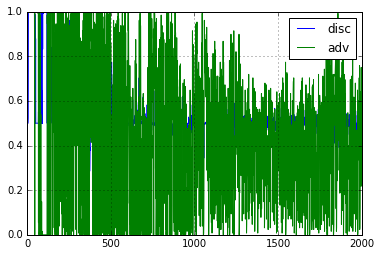

In [123]:
plt.plot(disc_losses["acc"], label="disc")
plt.plot(adv_losses["acc"], label="adv")
plt.grid()
plt.legend()
plt.show()

## An attempt to generate images

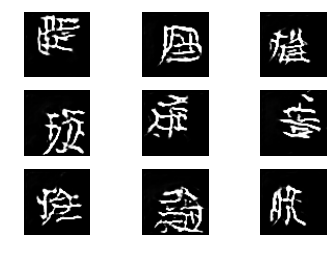

In [125]:
noise = np.random.uniform(-1.0, 1.0, size=[9, gen_noise_dim])
# noise = np.random.normal(size=[9, gen_noise_dim])
fake_images = gennet.predict(noise)

    
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(fake_images[i].reshape(img_size, img_size), cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()